In [1]:
# .. ... .... .. .....

In [2]:
# import dependencies
import yfinance as yf
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tqdm.notebook import tqdm_notebook as bar
import warnings
import matplotlib.pyplot as plt

In [3]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
warnings.filterwarnings('ignore')

In [4]:

# Define the ticker symbol of the financial instrument you're interested in
ticker = "AAPL"  # Apple Inc. stock

# Retrieve historical data
data = yf.download(ticker, start="2000-01-01", end="2021-12-31")

# Print the first few rows of the dataset



[*********************100%***********************]  1 of 1 completed


In [5]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,5535.000000,5535.000000,5535.000000,5535.000000,5535.000000,5.535000e+03
mean,24.254609,24.512803,23.998591,24.266556,22.980999,4.292185e+08
std,34.572185,34.961910,34.199711,34.601415,34.199165,3.893148e+08
min,0.231964,0.235536,0.227143,0.234286,0.199130,3.934000e+07
25%,1.541786,1.565893,1.521786,1.538929,1.308001,1.588328e+08
50%,11.612857,11.658929,11.501786,11.612857,9.870262,3.154368e+08
75%,29.756250,29.981250,29.561250,29.815000,27.306857,5.706554e+08
max,181.119995,182.130005,178.529999,180.330002,178.768845,7.421641e+09


In [6]:
data.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [7]:
data.dtypes

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [8]:
# Define the LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, input):
        lstm_out, _ = self.lstm(input.view(len(input), 1, -1))
        output = self.fc(lstm_out.view(len(input), -1))
        return output[-1]

In [9]:
# Define hyperparameters
input_size = 1  # Number of features in the input (volume)
hidden_size = 32  # Number of units in the LSTM hidden state
output_size = 1  # Number of features in the output (adjusted value)
num_epochs = 100
learning_rate = 0.001

In [10]:
# Instantiate the LSTM model
model = LSTM(input_size, hidden_size, output_size)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Generate some example data (replace with your own dataset)
num_samples = 1000

In [11]:
volume = data.Volume.to_numpy().reshape(-1,1)
adjusted_values = data.iloc[:, -1].to_numpy().reshape(-1, 1)

# scaling of inputs and outputs
scale_X = MinMaxScaler()
scale_Y = MinMaxScaler()
volume = scale_X.fit_transform(volume)
adjusted_values = scale_Y.fit_transform(adjusted_values)

# splitting data into training and testing
volume_train, volume_test, adj_train, adj_test = train_test_split(volume, adjusted_values,
                                                                 test_size= 0.8,
                                                                 random_state=42)

# Convert data to PyTorch tensors
volume_train = torch.Tensor(volume_train)
volume_test = torch.Tensor(volume_test)
adj_train = torch.Tensor(adj_train)
adj_test = torch.Tensor(adj_test)

In [12]:
# Training loop
train_losses = []
test_losses = []

for epoch in bar(range(num_epochs)):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    train_outputs = model(volume_train)
    train_loss = criterion(train_outputs, adj_train)

    # Backward pass and optimization
    train_loss.backward()
    optimizer.step()

    # Evaluation on test data
    model.eval()
    test_outputs = model(volume_test)
    test_loss = criterion(test_outputs, adj_test)

    # Save the loss values
    train_losses.append(train_loss.item())
    test_losses.append(test_loss.item())
    
     # Print the loss for every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch \033[1m{epoch+1}/{num_epochs}\033[0m, Train Loss: \033[1m{train_loss.item():.4f}\033[0m, Test Loss: \033[1m{test_loss.item():.4f}\033[0m')

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 10/100, Train Loss: 0.0029, Test Loss: 0.0029
Epoch 20/100, Train Loss: 0.0031, Test Loss: 0.0035
Epoch 30/100, Train Loss: 0.0026, Test Loss: 0.0029
Epoch 40/100, Train Loss: 0.0026, Test Loss: 0.0029
Epoch 50/100, Train Loss: 0.0025, Test Loss: 0.0028
Epoch 60/100, Train Loss: 0.0025, Test Loss: 0.0029
Epoch 70/100, Train Loss: 0.0025, Test Loss: 0.0028
Epoch 80/100, Train Loss: 0.0025, Test Loss: 0.0028
Epoch 90/100, Train Loss: 0.0025, Test Loss: 0.0028
Epoch 100/100, Train Loss: 0.0025, Test Loss: 0.0028


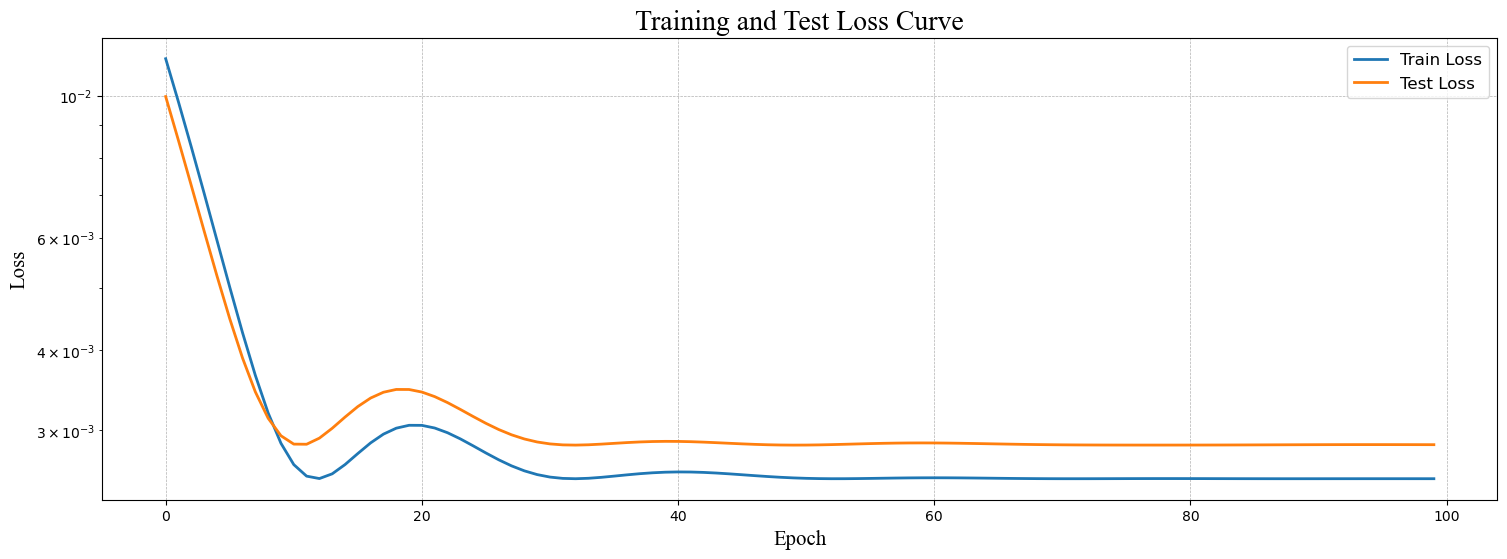

In [18]:
# Plot the loss curve
plt.figure(figsize=(18, 6))
plt.plot(train_losses, label='Train Loss', linewidth=2)
plt.plot(test_losses, label='Test Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=15, fontname = 'times new roman')
plt.ylabel('Loss', fontsize=15, fontname = 'times new roman')
plt.yscale('log')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Training and Test Loss Curve', fontsize=20, fontname = 'times new roman')
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()
